In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import geopandas as gpd
from shapely.geometry import Point, LineString

In [2]:
#Funkcje
#Generacja populacji początkowej o zadanych ilościach osobników i miast
def pop_pocz(n_pop, n_miast) :
    pop = pd.DataFrame()
    for i in range(n_pop) :
        pop[i] = random.sample(range(1,n_miast+1), n_miast)
    pop = pop.T
    pop.index = list(range(1,n_pop+1))
    pop.index.name = "Nr"
    pop.columns = list(range(1,n_miast+1))
    
    return pop
    
#Obliczanie odległości miast od siebie
def odl(x1,y1,x2,y2):
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)

#Obliczenie sumy odległości
def sum_odl(os) :
    sum = 0
    for i in range(1, len(os)):
        sum += odl(x[os[i]-1], y[os[i]-1], x[os[i+1]-1], y[os[i+1]-1])
    sum += odl(x[os[n_miast]-1], y[os[n_miast]-1], x[os[1]-1], y[os[1]-1])
    return sum

#Selekcja
def best_os(pop, n_pop, n_naj) :
    pop_odl = []
    for i in range(1, n_pop+1) :
        os = pop.loc[i]
        pop_odl.append(sum_odl(os))

    df = pd.DataFrame(pop_odl, columns=["Suma odległości"], index = list(range(1,n_pop+1)))
    df = df.sort_values(by="Suma odległości").head(n_naj)
    best = pop.loc[df.index]

    return [df, best]

def krzyzowanie(n_naj,best,n_miast):
    a = random.sample(range(0, n_naj), n_naj)
    index = random.randint(0, n_miast-1)
    ile = random.randint(1, n_miast)
    krzyzowanie = pd.DataFrame(columns = list(range(1,n_miast+1)))
    
    if (index + ile) >= n_miast:
        ile = 39 - index
    
    for i in range(len(a)):
        if i % 2 == 0:
            b = list((best.iloc[a[i],:]))
            c = list((best.iloc[a[i+1],:]))
            for i in range(ile):
                temp = b[index+i]
                b[index+i] = c[index+i]
                c[index+i] = temp
    
            zduplikowane_b = []
            for liczba in b:
                if b.count(liczba) > 1 and liczba not in zduplikowane_b:
                    zduplikowane_b.append(liczba)
                
            zduplikowane_c = []
            for liczba in c:
                if c.count(liczba) > 1 and liczba not in zduplikowane_c:
                    zduplikowane_c.append(liczba)
            indexes_b = []
            for i in zduplikowane_b:
                for ind, value in enumerate(b):
                    if value == i:
                        if ind < index or ind >= index + ile:
                            indexes_b.append(ind)
            indexes_c = []
            for i in zduplikowane_c:
                for ind, value in enumerate(c):
                    if value == i:
                        if ind < index or ind >= index + ile:
                            indexes_c.append(ind)
                            
            for i in range(len(indexes_b)):
                temp = b[indexes_b[i]]
                b[indexes_b[i]] = c[indexes_c[i]]
                c[indexes_c[i]] = temp
            krzyzowanie.loc[len(krzyzowanie)] = b
            krzyzowanie.loc[len(krzyzowanie)] = c
    return krzyzowanie

def mutacja(krzy,n_naj,n_miast):
    for i in range(n_naj):
        if random.randint(1, n_miast/2) == 1:
            gen1 = random.randint(0, n_miast-1)
            gen2 = random.randint(0, n_miast-1)
            temp = krzy.iloc[i,gen1]
            krzy.iloc[i,gen1] = krzy.iloc[i,gen2]
            krzy.iloc[i,gen2] = temp
    return krzy

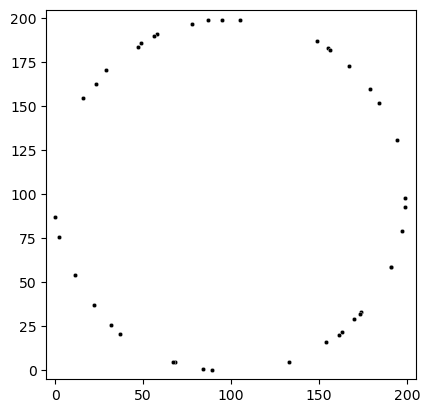

In [3]:
n_pop = 40
n_miast = 40
n_naj = 20
r = 100

x =[]
y =[]
for i in range(n_miast):
    kat = random.uniform(0, 2 * math.pi)
    xx = int(100*math.cos(kat)+r)
    yy = int(100*math.sin(kat)+r)
    x.append(xx)
    y.append(yy)
    
sns.scatterplot(x=x,y=y, s=10, color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5,205)
plt.ylim(-5,205)
plt.show()

In [4]:
#Stworzenie populacji początkowej
pop_p = pop_pocz(n_pop, n_miast)
df, best = best_os(pop_p, n_pop, n_naj)
krz = krzyzowanie(n_naj,best,n_miast)
mut = mutacja(krz,n_naj,n_miast)
best1 = pd.concat((best,mut))
best1.index = list(range(1,n_pop+1))
best1.index.name = "Nr"
best1.columns = list(range(1,n_miast+1))
best1.head(10)

for i in range(1,len(best1)):
    val = len(best1.loc[i,:].unique())
    if val != 40: print(val)

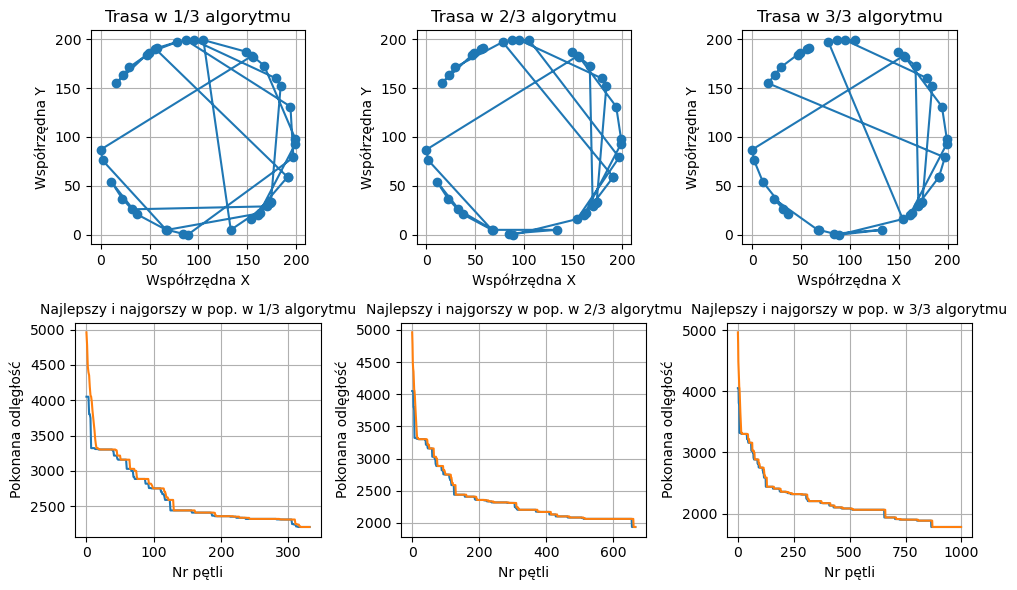

In [5]:
#W pętli generowanie kolejnych populacji z punktami kontrolnymi w 1/3 i 2/3 algorytmu w celu wyświetlenia zmian
fig, ax = plt.subplots(2,3, figsize=(10,6))
opty = []
sr = []
for j in range(3) :
    for i in range(333) :
        df, best = best_os(best1, n_pop, n_naj)
        opty.append(df.iloc[0,0])
        sr.append(df.iloc[n_naj-1,0])
        krz = krzyzowanie(n_naj,best,n_miast)
        mut = mutacja(krz,n_naj,n_miast)
        best1 = pd.concat((best,mut))
        best1.index = list(range(1,n_pop+1))
        best1.index.name = "Nr"
        best1.columns = list(range(1,n_miast+1))
        for i in range(1,len(best1)):
            val = len(best1.loc[i,:].unique())
            if val != 40: print(val)
    indeksy_kolejnych_punktow =  list((best.iloc[0,:]))

    ax[0, j].plot([x[i-1] for i in indeksy_kolejnych_punktow], [y[i-1] for i in indeksy_kolejnych_punktow], marker='o')
    ax[0, j].set_title('Trasa w {}/3 algorytmu'.format(j+1))
    ax[0, j].set_xlabel('Współrzędna X')
    ax[0, j].set_ylabel('Współrzędna Y')
    ax[0, j].set_aspect('equal')
    ax[0, j].grid(True)

    ax[1,j].plot(opty)
    ax[1,j].plot(sr)
    ax[1, j].set_title('Najlepszy i najgorszy w pop. w {}/3 algorytmu'.format(j+1), fontsize=10)
    ax[1, j].set_xlabel('Nr pętli')
    ax[1, j].set_ylabel('Pokonana odlęgłość')
    ax[1, j].grid(True)

plt.tight_layout()
plt.show()

In [6]:
#Najlepsza odległość w pierwszej i ostatniej populacji
print(opty[0], opty[-1])

4050.2250682640065 1780.7746807241047


PROJ: proj_create_from_database: Cannot find proj.db


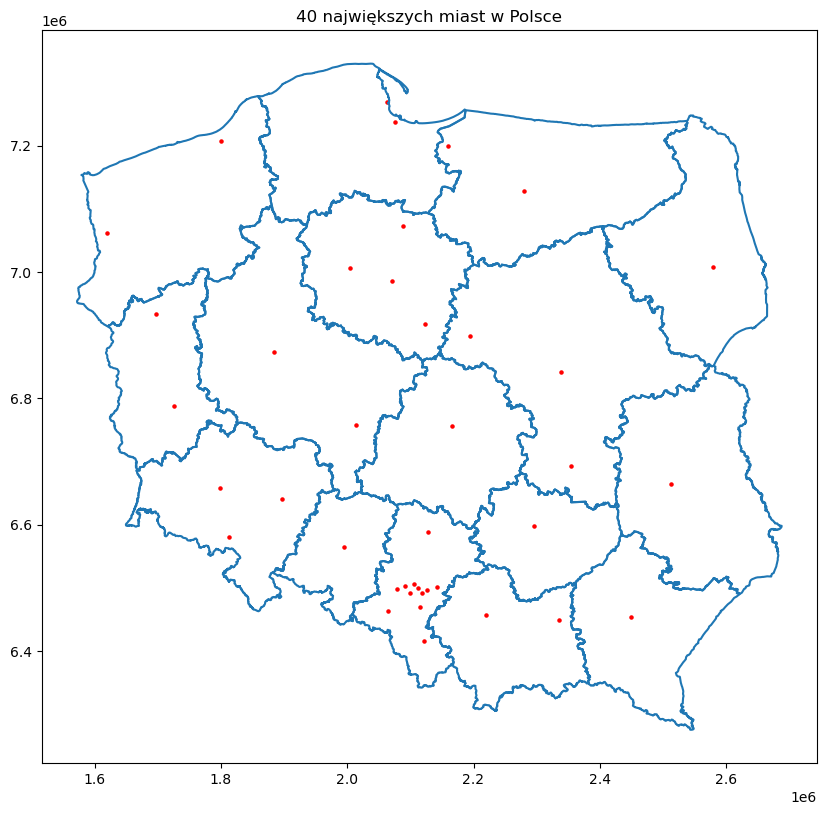

In [7]:
dane = pd.read_csv("miasta.csv", sep=';', header=1)
woj = gpd.read_file("Wojewodztwa_geometria.zip", encoding="utf-8")
woj = woj.to_crs(3857)

gdf = gpd.GeoDataFrame(
    dane, 
    geometry=gpd.points_from_xy(dane.długosc, dane.szerokosc)
)

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)

names = dane["miasto"]
x = dane["długosc"]
y = dane["szerokosc"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
woj.boundary.plot(ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title('40 największych miast w Polsce')
plt.show()

In [8]:
#Stworzenie populacji początkowej
pop_p = pop_pocz(n_pop, n_miast)
df, best = best_os(pop_p, n_pop, n_naj)
krz = krzyzowanie(n_naj,best,n_miast)
mut = mutacja(krz,n_naj,n_miast)
best1 = pd.concat((best,mut))
best1.index = list(range(1,n_pop+1))
best1.index.name = "Nr"
best1.columns = list(range(1,n_miast+1))
best1.head(10)

for i in range(1,len(best1)):
    val = len(best1.loc[i,:].unique())
    if val != 40: print(val)

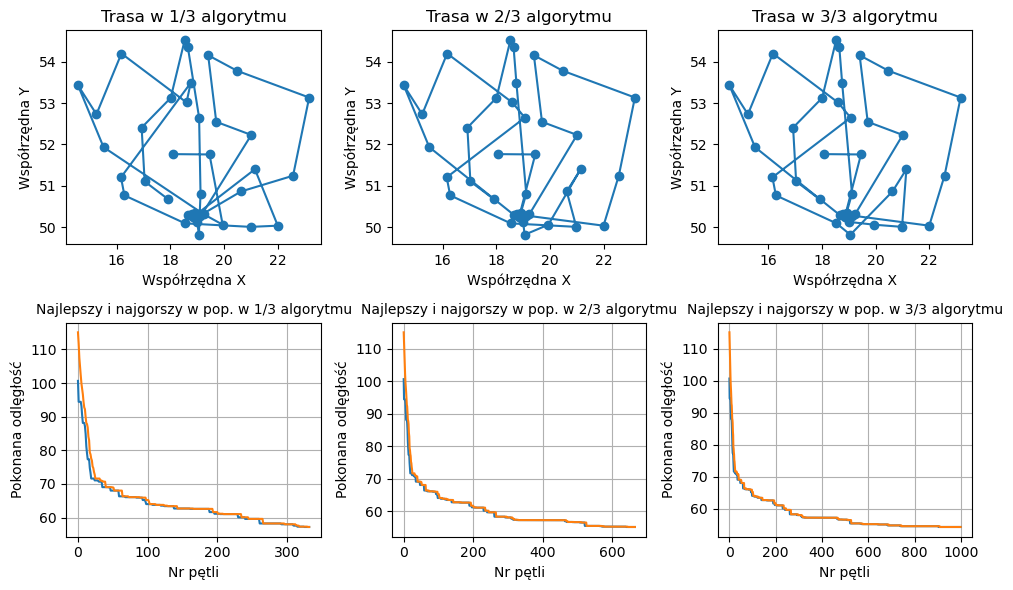

In [9]:
#W pętli generowanie kolejnych populacji z punktami kontrolnymi w 1/3 i 2/3 algorytmu w celu wyświetlenia zmian
#W tym przypadku ze względu na połączenie miast, wykonywany jest normalny plot, a nie ten z geopandas.
#Mimo to można bez problemu zaobserwować poprawę trasy
#Odległości podawane są w stopniach geograficznych, ale nie jest to przeszkodą to zauważenia poprawy trasy
fig, ax = plt.subplots(2,3, figsize=(10,6))
opty = []
sr = []
for j in range(3) :
    for i in range(333) :
        df, best = best_os(best1, n_pop, n_naj)
        opty.append(df.iloc[0,0])
        sr.append(df.iloc[n_naj-1,0])
        krz = krzyzowanie(n_naj,best,n_miast)
        mut = mutacja(krz,n_naj,n_miast)
        best1 = pd.concat((best,mut))
        best1.index = list(range(1,n_pop+1))
        best1.index.name = "Nr"
        best1.columns = list(range(1,n_miast+1))
        for i in range(1,len(best1)):
            val = len(best1.loc[i,:].unique())
            if val != 40: print(val)
    indeksy_kolejnych_punktow =  list((best.iloc[0,:]))

    ax[0, j].plot([x[i-1] for i in indeksy_kolejnych_punktow], [y[i-1] for i in indeksy_kolejnych_punktow], marker='o')
    ax[0, j].set_title('Trasa w {}/3 algorytmu'.format(j+1))
    ax[0, j].set_xlabel('Współrzędna X')
    ax[0, j].set_ylabel('Współrzędna Y')
    #ax[0, j].set_aspect('equal')
    #ax[0, j].grid(True)

    ax[1,j].plot(opty)
    ax[1,j].plot(sr)
    ax[1, j].set_title('Najlepszy i najgorszy w pop. w {}/3 algorytmu'.format(j+1), fontsize=10)
    ax[1, j].set_xlabel('Nr pętli')
    ax[1, j].set_ylabel('Pokonana odlęgłość')
    ax[1, j].grid(True)

plt.tight_layout()
plt.show()

In [10]:
#Najlepsza odległość w pierwszej i ostatniej populacji
print(opty[0], opty[-1])

100.65948738972841 54.3036815428639
